## <center> INTRACRANIAL HEMORRHAGES DATABASE - INFERENTIAL STATISTICS - SURVIVAL ANALYSIS</center>

This Notebook conducts a survival analysis of patients who have suffered an intracranial hemorrhage. Survival is defined as survival to hospitalization discharge. Different biostatiscal techniques are used for that purpose, including the well-known Kaplain-Meier estimator, Mantel-Cox (log-rank) test, and the state-of-the-art method for survival prediction until the last adaptations of machine learning algorithms for survival analysis, Cox Proportional Hazards regression.

**1. Load dataset**

**2. Define survival variables**

- **Survival variables**
- **Status plot**

**3. Survival functions**

- **Definitions**
- **Kaplain-Meier estimator (non-parametric approach)**
- **Mantel-Cox test (Log-rank)**

**4. Cox Proportional Hazards regression (semi-parametric approach)**

- **Definition**
- **Study of predictors**
- **Simple Cox Regression**
- **Cox net - regression with elastic net penalty**

NOTE: Parametric methods for estimating the survival and cumulative hazard functions are included in *Notebook 8. Random Survival Forest and Gradient Boosted Models*.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from lifelines import KaplanMeierFitter, CoxPHFitter
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from time import time
import warnings

### Silent warnings

In [2]:
warnings.filterwarnings('ignore')

### 1. Load dataset

In [3]:
df= pd.read_hdf('Databases/ICH_database.hdf5')
df_metadata= pd.read_csv('Databases/ICH_database_metadata.csv')
df.head(4)

,patient,sex,hospital,follow_up,final_outcome,nfamily_medhist,tobacco,n_tobacco,drugs,alcohol,...,rdw,mchc,mpv,mch,inr,fibrinogen,maxfibrinogen,time_between_CT_bloodanalysis,age,survival_days
0,1,1,1.0,2.0,2.0,17,2.0,NaN,0,0,...,17.0,33.0,9.0,28.1,4.21,344.0,618.0,0,74,4
1,2,2,2.0,0.0,1.0,4,0.0,0.0,0,0,...,14.7,32.5,10.7,29.8,NaN,NaN,1081.0,0,81,2128
2,3,2,1.0,0.0,0.0,8,0.0,0.0,0,0,...,14.0,33.1,8.7,30.1,3.16,298.0,470.0,0,78,2388
3,4,2,1.0,2.0,2.0,8,0.0,0.0,0,0,...,15.8,34.1,7.6,19.3,1.09,344.0,344.0,0,79,7


### 2. Define survival variables

- **Survival variables**
- **Status plot**

### 2.1. Survival variables

**Survival analysis** refers to a group of parametric and non-parametric statistical techniques use to analyze *time to event*. Although this field of biostatistics was developed to study survival, these techniques can be apply to study a time series associated with almost any kind of event.

Survival analysis usually requires two variables:
 - ***Status***: a binary variable indicating if the event (death) happened:
     - True or 1 (***uncensored***): the patient has died.
     - False or 0 (****censored*** or ****right censored***): patient did not suffered the event, either at the end of the study if follow-up was completed, or at the last follow-up if patient was missed during the follow-up so it was not completed. Therefore, two kind of patients can be found in this group: patients event free at the end of the study and patients missed during the follow-up. Results will be more reliable, as more patients have completed the follow-up.
 - ***Survival (Survival_in_days in this project)***: survival time registered measured in days.
 
In this project dataset, these variables are called *survival_discharge* and *survival_days*.

In [4]:
Status= np.array(df['survival_discharge'] == 0) # old value 0 (death), is changed for new value True or 1 (death)
Survival_in_days= np.array(df['survival_days'])

As survival analysis will be conducted using *scikit-survival*, survival variables have to be adapted to library requirements: 1D-array containing tuples (status, survival_days) with appropriate datatypes. Fortunately, the library has a function to automatically build the array.

In [5]:
y= Surv().from_arrays(event=Status, time=Survival_in_days, name_event='Status', name_time='Survival_in_days')

### 2.2. Status plot

Before starting a survival analysis, it is useful to check the **number of events** in the dataset. As medical datasets are often small comparing to datasets in other fields, the number of samples can be critical to decide some aspects of the further analysis, such as the number of covariables that can be introduced in a regression model, or the most appropriate algorithm to modelize the data. In the case of survival analysis, the oftenly limitant value is the number of events.

In [6]:
# Check Status
status, counts = np.unique(['Censored' if i[0] == False else 'Event' for i in y], return_counts = True)
dict(zip(status, counts))

{'Censored': 209, 'Event': 91}

Another important issue to check is the number of censors who are censors because they were missed during the follow-up. A common graph to visualize censored and uncensored data is the following (*only 10 patients are plotted for the stake of clarity*):

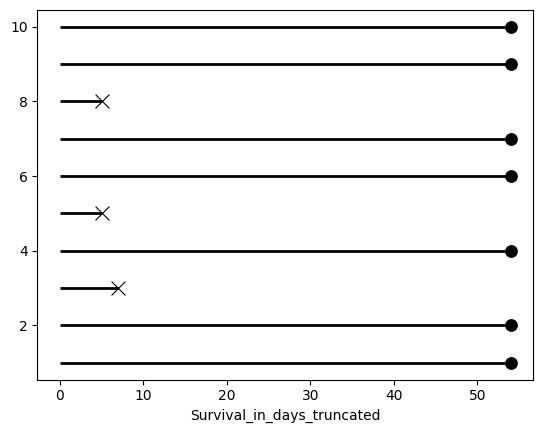

In [7]:
# Dataframe with markers
status_data= pd.DataFrame(y)
status_data['marker']= status_data['Status'].map({False:'o',True:'x'})

# Truncate to make it more fancy
max_death= max(status_data[status_data['Status'] == True]['Survival_in_days'])
status_data['Survival_in_days_truncated']= status_data['Survival_in_days']
status_data.loc[status_data['Survival_in_days_truncated'] > 54, 'Survival_in_days_truncated'] = 54


# Select a random sample to make it more fancy
sample= [1,2,3,4,5,6,7,8,9,10]
sample_data= status_data.iloc[sample,]

# Plot results
for x in sample_data.marker.unique():
    t= sample_data.loc[sample_data['marker']==x]
    g= sns.scatterplot(data=t, x='Survival_in_days_truncated', y=t.index.tolist(), marker=x, s=100, color='black')

for index, row in sample_data.iterrows():
    g.hlines(y=index, xmin=0, xmax=row['Survival_in_days_truncated'], linewidth=2, color='black')

### 3. Survival functions

- **Definitions**
- **Kaplain-Meier estimator**
- **Mantel-Cox test (Log-rank)**

### 3.1. Definitions

Survival analysis are based on some mathematical functions which explain the probability of survive or the probability of suffering the event (death). These function are the following:

**A. Survival function**

- A ***survival function*** expressed as $S(t)$ is a probability function containing the probability of survival to any event beyond a time ($t$).
    - $S(t) = P(T>t)$


- If there are no censoring:
    - $S(t)= \frac{Patients\;survived\;to\;time \;t}{Total\;number\;of\;patients}$


- Survival functions can be modeled following three approaches:
    - Parametric: accelerated failure time models, including normal distribution, Weibull distribution, exponential distribution, log-normal distribution, log-logistic distribution, gamma distribution, inverse gamma distribution.
    - Non-parametric: Kaplain-Meier.
    - Semi-parametric: Cox regression.
    
    
**B. Event functions**

- The complement of $S(t)$ is a cumulative distribution function conventionally denoted as $F(t)$, which gives the probability of the event occurrence (death) before or exactly at a time $t$:
    - ${\displaystyle F(t)=\Pr(T\leq t)=1-S(t).}$


- The density function associated to $F(t)$ is $f(t)$, and indicates the probability of event occurence at a exact time $t$:
    - ${\displaystyle f(t)=F'(t)={\frac {d}{dt}}F(t).}$


**C. Hazard function**

- Hazard refers to the instantaneous risk of the event. It measures how rapidly subjects are suffering the effect.
- Hazard ratio is an important concept to understand ***Cox Proportional Hazards model***, and it is a ratio of hazards, so it says how many times are the risk of death in one group compared to each other.
- Hazard function $h(t)$ estimates the instantaneous risk of the event at a time $t$, given that the individual has survived an instant before $t$:
    - ${\displaystyle h(t)=\lim _{dt\rightarrow 0}{\frac {\Pr(t\leq T<t+dt)}{dt\cdot S(t)}}={\frac {f(t)}{S(t)}}=-{\frac {S'(t)}{S(t)}}.}$


**D. Cumulative hazard function**
- Cumulative hazard function indicates the total accumulated risk of the event (death) at a time $t$.
- ${\displaystyle H(t)=-\log S(t)}$

### 3.2. Kaplan-Meier estimator (non-parametric approach)

***Kaplan-Meier estimator*** is one of the most used techniques in bioestatistics to estimate survival functions. Kaplain-Meier estimator is a non-parametric method which properly manages censured data. The result is a step function, whose steps are all the time points ($t_{i}$) where one or more patients died.

- ${\displaystyle {\hat {S}}(t)=\prod \limits _{t_{i}<t}{\frac {n_{i}-d_{i}}{n_{i}}}.}$

     - $n_{i}$: number of patients at risk just before a time $t_{i}$. If there are not censure, it is equal to the number of survivals before a time $t_{i}$.

     - $d_{i}$: number of events (deaths) occurred at a time $t_{i}$.

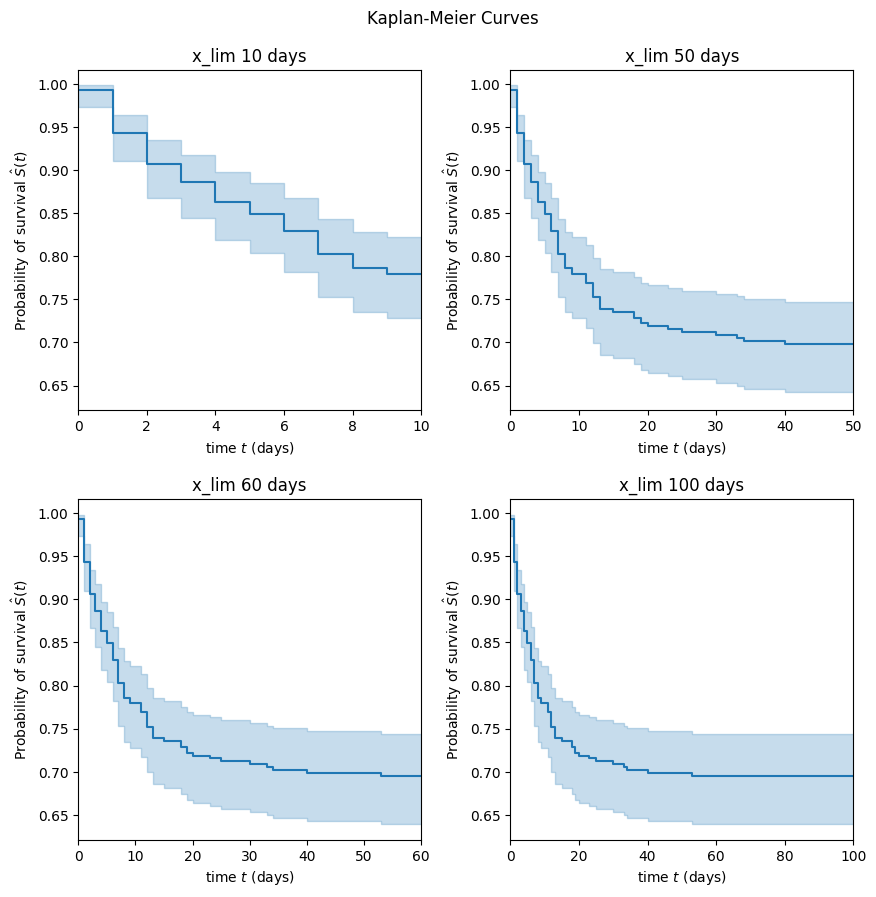

In [8]:
#time, survival_prob= kaplan_meier_estimator(Status, Survival_in_days)

fig, axs= plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Kaplan-Meier Curves', fontsize=12, y=0.94)

lim= [10,50,60,100]
counter= 0
for i in range(2):
    for j in range(2):
        #axs[i,j].step(time, survival_prob, where='post')
        KaplanMeierFitter().fit(Survival_in_days, Status).plot(ax=axs[i,j])
        axs[i,j].get_legend().remove()

        axs[i,j].set_title('x_lim ' + str(lim[counter]) + ' days')
        axs[i,j].set_ylabel('Probability of survival $\hat{S}(t)$')
        axs[i,j].set_xlabel('time $t$ (days)')
        axs[i,j].set_xlim([0,lim[counter]])
        counter+=1
        
plt.subplots_adjust(hspace=0.26, wspace=0.26)

### 3.3. Mantel-Cox test (Log-rank)

In survival analysis, ***Mantel-Cox test***, also known as ***log rank***, is a statistical technique for comparing survival functions. It is a **non-parametric** test based on the *Chi-square test* that can be used in presence of censored data.

In [9]:
# Define a log rank test function
def logrank(y, df, variable, decimals, counts=False):
    
    idx_nan= np.isnan(pd.to_numeric(df[variable])) # exclude nan
    lk_result= compare_survival(y=y[~idx_nan], group_indicator=df[variable][~idx_nan], return_stats=True)
    p_value= round(lk_result[1], decimals)
    
    if counts == True: print(lk_result[2])
    
    return(p_value)

*Log rank test* is the appropriate statistical technique to compare *survival functions*. In biostatistics, usually **the grouping variables are qualitative**, since transforming a quantitative variable into categorical by making intervals in order to separate *survival functions*, is not considered a good practice when talking about *survival functions* and *logrank*.

In [10]:
cat_predictors= df_metadata[(df_metadata['Pandas_Datatype'] == 'category') &
                            (df_metadata['Type_of_Variable'].str.contains('Predictor'))]['Variable_Label'].values.tolist()

In [11]:
# Do the logrank tests
p_value_logrank= [logrank(y=y, df=df, variable=cat_predictor, decimals=4, counts=False)
                                for cat_predictor in cat_predictors]

# Adjust p.values by FDR
p_adj_logrank= fdrcorrection(np.array(p_value_logrank), method='indep', is_sorted=False)[1]

# Build a dataframe
p_adj_logrank= pd.DataFrame(data={'variable':cat_predictors,
                                  'p_value':p_value_logrank,
                                  'p_adj_fdr':np.round(p_adj_logrank,4)})

# Filter by significant tests
alpha_logrank= 0.05
significative_logrank= p_adj_logrank[p_adj_logrank['p_adj_fdr'] < alpha_logrank]
significative_logrank

,variable,p_value,p_adj_fdr
9,carrhythmias,0.0040,0.0356
24,arbs,0.0017,0.0272
45,dabigatran,0.0000,0.0000
53,mh_le_trauma,0.0073,0.0487
55,other_symptoms,0.0030,0.0343
56,neurol_signs,0.0049,0.0392
58,anisocoria,0.0000,0.0000
61,altered_consciousness,0.0000,0.0000
70,tgcs,0.0000,0.0000
71,primary_ich,0.0023,0.0307


Sometimes, *correction of p-values* are too conservative. Thus, it is useful to see the associations which are near the significance.

In [12]:
# Associations which were significant at the beggining, but FDR correction turn them into non-significant
near_sig_logrank= p_adj_logrank[(p_adj_logrank['p_value'] < alpha_logrank) & (p_adj_logrank['p_adj_fdr'] > alpha_logrank)]
near_sig_logrank

,variable,p_value,p_adj_fdr
10,structural_heart_disease,0.0104,0.0530
30,diuretics,0.0214,0.1007
33,sulfonylureas,0.0099,0.0530
43,cumarinics,0.0106,0.0530
52,mh_trauma,0.0097,0.0530
67,rlwlimb_mimpairment,0.0280,0.1244


#### 3.3.1. Check for counts

Checking for counts is a good practice to be sure that results are reliable.

In [13]:
# Check for counts
sig_or_near_sig= significative_logrank['variable'].tolist() + near_sig_logrank['variable'].tolist()

for sig in sig_or_near_sig:
    print('\n', sig)
    logrank(y=y, df=df, variable=sig, decimals=4, counts=True)


 carrhythmias
       counts  observed   expected  statistic
group                                        
0         235        62  72.833398 -10.833398
1          65        29  18.166602  10.833398

 arbs
       counts  observed   expected  statistic
group                                        
0         257        69  79.022126 -10.022126
1          43        22  11.977874  10.022126

 dabigatran
       counts  observed   expected  statistic
group                                        
0         298        89  90.885657  -1.885657
1           2         2   0.114343   1.885657

 mh_le_trauma
       counts  observed   expected  statistic
group                                        
0.0       189        68  55.680655  12.319345
1.0       110        23  35.319345 -12.319345

 other_symptoms
       counts  observed   expected  statistic
group                                        
0.0       137        52  38.247243  13.752757
1.0       161        38  51.752757 -13.752757

 neurol_sign

#### 3.3.2. Visualization

Visualization of statistical results is often a must. Although hypothesis contrasts are objetive whereas visualization assements are subjective, plots can sometimes give a further perspective than hypothesis tests do.

In [14]:
# Define a function to get separated survival functions by group
def kaplan_meier_comp (df, group, groups, status, survival):
    
    group1= df[df[group] == groups[0]]
    group2= df[df[group] == groups[1]]
    
    Status1= np.array(group1[status] == 0)
    Survival_in_days1= np.array(group1[survival])
    
    Status2= np.array(group2[status] == 0)
    Survival_in_days2= np.array(group2[survival])
    
    time1, survival_prob1= kaplan_meier_estimator(Status1, Survival_in_days1)
    time2, survival_prob2= kaplan_meier_estimator(Status2, Survival_in_days2)
    
    functions= [(time1, survival_prob1), (time2, survival_prob2)]
    
    return (functions)

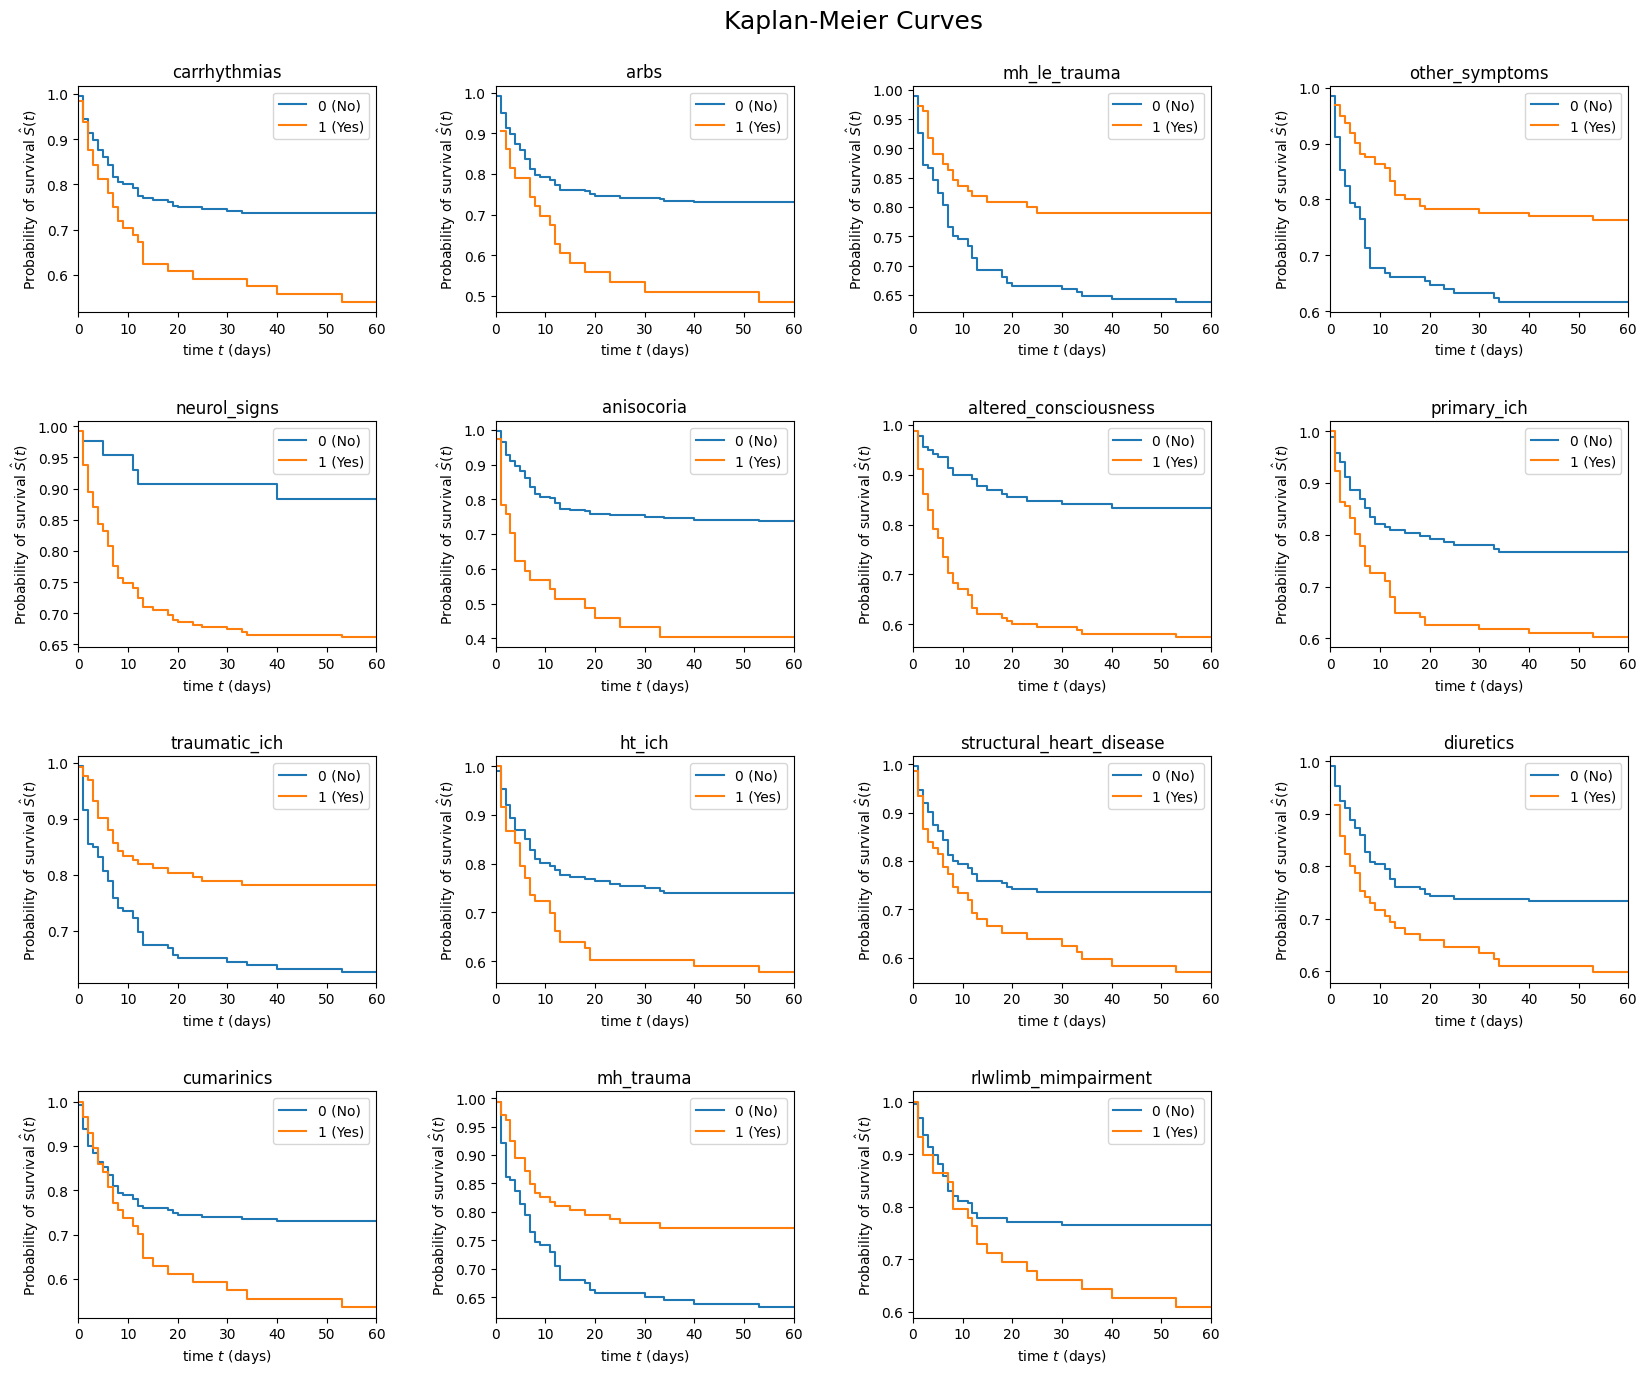

In [15]:
groups= sig_or_near_sig[:]
groups.remove('tgcs') # Delete non-binary variables
groups.remove('dabigatran') # Delete variables without enough n in one group
groups.remove('sulfonylureas')

fig= plt.figure(figsize=(20,16))
plt.title('Kaplan-Meier Curves', fontsize=18, y=1.04)
plt.axis('off')


counter= 1
for group in groups:
    functions= kaplan_meier_comp (df, group, (0,1), status='survival_discharge', survival='survival_days')
    
    ax= fig.add_subplot(4,4, counter)
    ax.step(functions[0][0], functions[0][1], where='post', label='0 (No)')
    ax.step(functions[1][0], functions[1][1], where='post', label='1 (Yes)')
    
    ax.set_title(group)
    ax.set_ylabel('Probability of survival $\hat{S}(t)$')
    ax.set_xlabel('time $t$ (days)')
    ax.set_xlim([0,60])
    ax.legend()
    counter+=1
        
plt.subplots_adjust(hspace=0.48, wspace=0.4)

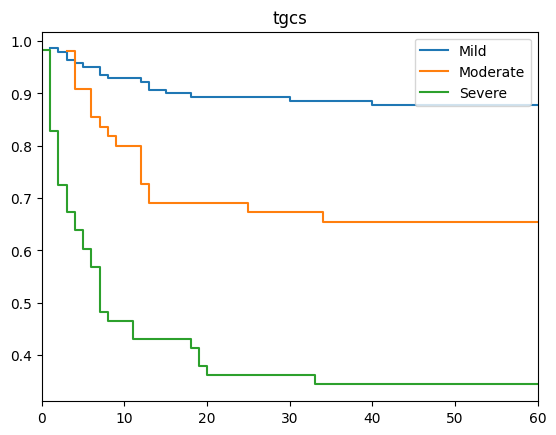

In [16]:
df['tgcs2']= pd.to_numeric(df['tgcs'])

Status1= np.array(df[df['tgcs2'] > 12]['survival_discharge'] == 0)
Status2= np.array(df[(df['tgcs2'] >= 8) & (df['tgcs2'] <= 12)]['survival_discharge'] == 0)
Status3= np.array(df[df['tgcs2'] < 8]['survival_discharge'] == 0)
    
Survival_in_days1= np.array(df[df['tgcs2'] > 12]['survival_days'])
Survival_in_days2= np.array(df[(df['tgcs2'] >= 8) & (df['tgcs2'] <= 12)]['survival_days'])
Survival_in_days3= np.array(df[df['tgcs2'] < 8]['survival_days'])
    
time1, survival_prob1= kaplan_meier_estimator(Status1, Survival_in_days1)
time2, survival_prob2= kaplan_meier_estimator(Status2, Survival_in_days2)
time3, survival_prob3= kaplan_meier_estimator(Status3, Survival_in_days3)


fig= plt.figure()

plt.step(time1, survival_prob1, where='post', label='Mild')
plt.step(time2, survival_prob2, where='post', label='Moderate')
plt.step(time3, survival_prob3, where='post', label='Severe')

plt.title('tgcs')
plt.xlim([0,60])
plt.legend()

### 4. Cox Proportional Hazards regression (semi-parametric approach)

- **Definition**
- **Study of predictors**
- **Simple Cox Regression**
- **Cox Net - regression with elastic net penalty**

### 4.1. Definition

*Kaplan-Meier estimator* and *log rank tests* are *univariate* analysis which do not work easily for quantitative predictors. Therefore, there is a need of a statistical technique able to do **multivariate survival analysis** and able to manage with **quantitative predictors**. This technique is ***Cox proportional hazards regression***. 

<center>$h(t|xᵢ)=h₀(t)exp(β'xᵢ)$</center>

 - $h(t|xᵢ)$: hazard function.
 - $h₀(t)$: baseline hazard function: risk without the intervention of risk factors.
 - $exp(β'xᵢ)$: relative risks or hazard ratios: risk added by risk factors.

*Cox regression* is based on ***hazard ratios***, which indicate how many times the risk factor increases or decreases the risk of the event.

The **assumptions** of *Cox model* includes:
   - Independence of survival times between distinct individuals in the sample.
   - A multiplicative relationship between the predictors and the hazard.
   - A constant hazard ratio over time.

The first step for training a *Cox model*, is to convert data into numeric.

In [17]:
df_numeric= df.apply(pd.to_numeric)

### 4.2. Study of predictors

Before starting with *Cox regression*, it is possible to fit a single and **univariate** regression for each feature, to explore which single variable is the best risk predictor. 

In [18]:
# Delete non-useful columns
cols= df_numeric.columns.tolist()
cols.remove('patient')
cols.remove('survival_discharge')
cols.remove('survival_days')
cols.remove('time_between_CT_bloodanalysis')
cols.remove('tgcs2')

df_numeric= df_numeric[cols]

In [19]:
# Define a Cox regression function
def fit_and_score_features(df_numeric, y):

    n_features= df_numeric.shape[1]
    coefs= np.empty(n_features)
    scores= np.empty(n_features)
    cox_reg= CoxPHSurvivalAnalysis()
    
    for idx_feature in range(n_features):
        
        X= df_numeric[:,idx_feature]
        idX_nan= np.isnan(X) # exclude nan
        X2= X[~idX_nan,].reshape(-1, 1)
        y2= y[~idX_nan,]
        
        cox_reg.fit(X2, y2)
        coefs[idx_feature]= cox_reg.coef_[0]
        scores[idx_feature]= cox_reg.score(X2, y2)
        
    return coefs, scores

In [20]:
# Fit one regression per variable, and order the results
uni_scores= fit_and_score_features(df_numeric.values,y)

scores= pd.DataFrame(data={'coef \u03B2':uni_scores[0],
                           'exp(\u03B2)': np.exp(uni_scores[0]),
                           'score': uni_scores[1]},
                     index= df_numeric.columns).sort_values(by='score', ascending=False)

In [21]:
round(scores[(scores['score'] > 0.60) & (scores.index.str.contains('surviv') == False)],2)

,coef β,exp(β),score
final_outcome,1.07,2.90,0.90
follow_up,1.63,5.11,0.89
hospitalization_days,-0.12,0.89,0.82
tgcs,-0.22,0.80,0.78
hospitalizations_5y,-19.36,0.00,0.74
hospitalizations_3y,-18.74,0.00,0.71
glucose,0.01,1.01,0.66
inr,0.17,1.19,0.64
altered_consciousness,1.12,3.07,0.63
onset_h,-0.00,1.00,0.63


### 4.3. Simple Cox regression

- **Variables selection**
- **Cross-validation traning - preliminar confidence intervals**
- **Bootstrapping confidence intervals**
- **Final-Model interpretation**

#### 4.3.1. Variables selection

This previous analysis is useful to select the most relevant variables and fit a multivariant *Cox regression*.

In [22]:
cox_vars= ['hospitalization_days', 'tgcs', 'glucose', 'altered_consciousness', 'onset_h', 'prothrombin_activity']

*NOTE:* ***inr*** *was not included since it is highly correlated with* ***prothrombin_activity.***

Nonetheless, the variables selected to fit a regression should not only be those with highest statistical significance in univariate analysis, variables with high clinical meaning should also be included.

In [23]:
clinical_vars= ['age', 'sex', 'nfamily_medhist', 'cumarinics', 'neurol_signs', 'anisocoria', 'primary_ich', 'erythrocytes', 'creatinine', 'maxfibrinogen']

#### 4.3.2. Cross-validation traning - preliminar confidence intervals

Training a *regression* does not require to do a **cross-validation**, nonetheless it is a good technique to calculate a **preliminary confidence interval** for the accuracy, specially when dataset size is limited. Concerning the evaluation, metrics like MSE (quantitative predictions, regression) or accuracy (qualitative predictions, classification) do not work with survival data, since survival analysis adds one more layer of complexity, the censored data. In this cases, the metrics called **Harrell’s concordance index** or **c-index**, and **Uno’s c**, are the appropriate metrics to use. The second one is a modification of the first one, and it works better in presence of higher amount of censoring. It is an alternative to *Harrell’s concordance index* that does not depend on the distribution of censoring times in the test data.

In [24]:
# Define a function to do K-fold cross validation and calculate c-indexs
def cross_validation (x,y,k):
    
    idx= list(range(x.shape[0]))
    size= x.shape[0]/k
    x_, y_= shuffle(x,y) # shuffle to take random folds
    scores1= []
    scores2= []
    
    for fold in range(k):
        idx_test= list(range(int(fold*size),int((fold+1)*size)))
        idx_train= list(set(idx) - set(idx_test))
        
        cox_reg= CoxPHSurvivalAnalysis()
        cox_reg.fit(x_.values[idx_train,], y_[idx_train])
        
        score1= cox_reg.score(x_.values[idx_test], y_[idx_test]) # c-index
        prediction= cox_reg.predict(x_.values[idx_test])
        score2= concordance_index_ipcw(y_[idx_train], y_[idx_test], prediction) # Uno's c-index
        
        scores1.append(score1)
        scores2.append(score2[0])

    return (scores1, scores2)


# Define a function to exclude rows with NaN values
def exclude_nan (df, y, variables):
    df_vars= df[variables] # select variables
    idx_nan= df_vars.isna().any(axis=1) # exclude NaN
    df_vars= df_vars[~idx_nan]
    y_vars= y[~idx_nan]
    
    return df_vars, y_vars

In [25]:
df_cox_vars, y_cox  = exclude_nan(df_numeric, y, cox_vars) # variables with predictive power in univariate Cox
df_cox_vars2, y_cox2= exclude_nan(df_numeric, y, cox_vars[1:]) # exclude days of hospitalization
df_clin_vars, y_clin= exclude_nan(df_numeric, y, clinical_vars) # clinically relevant variables

all_vars= cox_vars[1:] + clinical_vars
df_all_vars, y_all  = exclude_nan(df_numeric, y, all_vars) # all variables, excluding hospitalization_days

cox_reg1_hc, cox_reg1_uc= cross_validation (x=df_cox_vars,  y=y_cox,  k=10) # Model 1 - Cox model
cox_reg2_hc, cox_reg2_uc= cross_validation (x=df_cox_vars2, y=y_cox2, k=10) # Model 2 - Cox2 model
cox_reg3_hc, cox_reg3_uc= cross_validation (x=df_clin_vars, y=y_clin, k=10) # Model 3 - Clinical model
cox_reg4_hc, cox_reg4_uc= cross_validation (x=df_all_vars,  y=y_all,  k=10) # Model 4 - Cox-clinical model


print('Model1 (c-index): %0.4f ± %0.4f' % (np.mean(cox_reg1_hc), np.std(cox_reg1_hc) * 1.96))
print('Model1 (c-uno):   %0.4f ± %0.4f' % (np.mean(cox_reg1_uc), np.std(cox_reg1_uc) * 1.96), '\n')

print('Model2 (c-index): %0.4f ± %0.4f' % (np.mean(cox_reg2_hc), np.std(cox_reg2_hc) * 1.96))
print('Model2 (c-uno):   %0.4f ± %0.4f' % (np.mean(cox_reg2_uc), np.std(cox_reg2_uc) * 1.96), '\n')

print('Model3 (c-index): %0.4f ± %0.4f' % (np.mean(cox_reg3_hc), np.std(cox_reg3_hc) * 1.96))
print('Model3 (c-uno):   %0.4f ± %0.4f' % (np.mean(cox_reg3_uc), np.std(cox_reg3_uc) * 1.96), '\n')

print('Model4 (c-index): %0.4f ± %0.4f' % (np.mean(cox_reg4_hc), np.std(cox_reg4_hc) * 1.96))
print('Model4 (c-uno):   %0.4f ± %0.4f' % (np.mean(cox_reg4_uc), np.std(cox_reg4_uc) * 1.96), '\n')

Model1 (c-index): 0.8301 ± 0.1766
Model1 (c-uno):   0.8287 ± 0.1794 

Model2 (c-index): 0.7978 ± 0.1880
Model2 (c-uno):   0.7978 ± 0.1881 

Model3 (c-index): 0.6920 ± 0.2266
Model3 (c-uno):   0.6921 ± 0.2270 

Model4 (c-index): 0.7272 ± 0.3705
Model4 (c-uno):   0.7263 ± 0.3723 



#### 4.3.3. Bootstrapping confidence intervals

Cross-validation results show that the best models are *Model 1 - Cox model* and *Model 2 - Cox2 model*, therefore, final confidence intervals should be calculated for both. A good technique is **bootstrapping**, by doing thousands of hold-out trainings and calculating the same number of metrics.

In [26]:
# Define a bootstrapping validation function
def boots_validation (x, y, train_size, n_iterations, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    x_, y_= shuffle(x,y) # shuffle to take random folds
    
    c_indexes= []
    c_unos= []
    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
                
        cox_reg= CoxPHSurvivalAnalysis()
        cox_reg.fit(x_.values[idx_train,], y_[idx_train])
        
        c_index= cox_reg.score(x_.values[idx_test], y_[idx_test]) # c-index
        prediction= cox_reg.predict(x_.values[idx_test])
        c_uno= concordance_index_ipcw(y_[idx_train], y_[idx_test], prediction) # Uno's c-index
        
        c_indexes.append(c_index)
        c_unos.append(c_uno[0])
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    c_index_median= np.median(c_indexes)
    c_index_lower= max(0.0, np.percentile(c_indexes, pl))
    c_index_upper= min(1.0, np.percentile(c_indexes, pu))

    c_uno_median= np.median(c_unos)
    c_uno_lower= max(0.0, np.percentile(c_unos, pl))
    c_uno_upper= min(1.0, np.percentile(c_unos, pu))
    
    
    return (c_indexes, c_unos,
           (c_index_median,c_index_lower,c_index_upper),
           (c_uno_median,c_uno_lower,c_uno_upper))


In [27]:
c_indexes_1, c_unos_1, ci_c_indexes_1, ci_unos_1= boots_validation (x=df_cox_vars,  y=y_cox,  train_size=0.8, n_iterations=10000, alpha=0.05)
c_indexes_2, c_unos_2, ci_c_indexes_2, ci_unos_2= boots_validation (x=df_cox_vars2, y=y_cox2, train_size=0.8, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

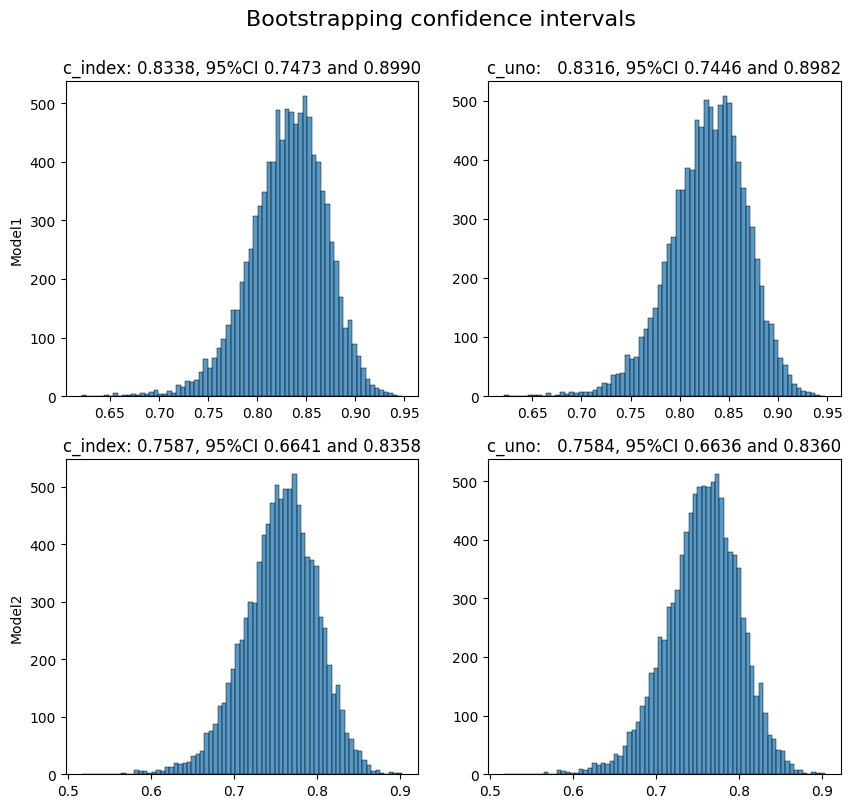

In [28]:
fig, axs= plt.subplots(2,2, figsize=(10,9))
fig.suptitle('Bootstrapping confidence intervals', y=0.96, size=16)

sns.histplot(c_indexes_1, ax=axs[0,0])
sns.histplot(c_unos_1,    ax=axs[0,1])
sns.histplot(c_indexes_2, ax=axs[1,0])
sns.histplot(c_unos_2,    ax=axs[1,1])

axs[0,0].set_ylabel('Model1')
axs[1,0].set_ylabel('Model2')
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')

alpha= 0.05
axs[0,0].set_title('c_index: %.4f, %.0f%%CI %.4f and %.4f' % (ci_c_indexes_1[0], (1-alpha)*100, ci_c_indexes_1[1], ci_c_indexes_1[2]))
axs[0,1].set_title('c_uno:   %.4f, %.0f%%CI %.4f and %.4f' % (ci_unos_1[0],      (1-alpha)*100, ci_unos_1[1],      ci_unos_1[2]))
axs[1,0].set_title('c_index: %.4f, %.0f%%CI %.4f and %.4f' % (ci_c_indexes_2[0], (1-alpha)*100, ci_c_indexes_2[1], ci_c_indexes_2[2]))
axs[1,1].set_title('c_uno:   %.4f, %.0f%%CI %.4f and %.4f' % (ci_unos_2[0],      (1-alpha)*100, ci_unos_2[1],      ci_unos_2[2]))

fig.subplots_adjust(hspace=0.2, wspace=0.2)

#### 4.3.4. Final-Model interpretation

Final model is **very interpretable**, as exp($\beta$i) are the **hazard ratios** of each factor.
 
   - $\beta$ > 0: hazard ratio > 1, increased risk of event (death).
   - $\beta$ < 0: hazard ratio < 1, reduced risk of event.

It is useful to transform coefficients, into **hazard ratios**.

In [29]:
cox_reg= CoxPHSurvivalAnalysis()
cox_reg.fit(df_cox_vars, y_cox) # final model trained with cox_vars
    
pd.DataFrame(data={'Risk factor':cox_vars,
                   'Coefficient [\u03B2]': np.round(cox_reg.coef_,4),
                   'Hazard ratio [exp(\u03B2)]': np.round(np.exp(cox_reg.coef_),4)})

,Risk factor,Coefficient [β],Hazard ratio [exp(β)]
0,hospitalization_days,-0.1057,0.8997
1,tgcs,-0.1722,0.8418
2,glucose,0.0057,1.0057
3,altered_consciousness,0.4518,1.5712
4,onset_h,-0.0049,0.9951
5,prothrombin_activity,-0.0105,0.9895


It is useful also to see the **confidence intervals** and ***p-values*** of pairwise Chi-square tests (although a different library is used, there can be slight differences in coefficient values).

In [30]:
df_X= df_numeric.copy()
df_X['Survival']= Survival_in_days
df_X['Status']= Status

X_,y_= exclude_nan(df_X, y, cox_vars+['Survival', 'Status'])

cph= CoxPHFitter().fit(X_, 'Survival', 'Status')
cph.print_summary(decimals=4)

<lifelines.CoxPHFitter: fitted with 170 total observations, 121 right-censored observations>
             duration col = 'Survival'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 170
number of events observed = 49
   partial log-likelihood = -191.0218
         time fit was run = 2023-06-12 16:07:49 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
hospitalization_days  -0.1114     0.8946     0.0219          -0.1544          -0.0685               0.8569               0.9338
tgcs                  -0.1830     0.8327     0.0462          -0.2737          -0.0924               0.7606               0.9117
glucose                0.0056     1.0056     0.0024           0.0009           0.0103               1.0009               1.0104
altered_consciousness  0.4471     1.5638     0.4068          -0.3503           1.2445               0.7045               3.4712
onset_h               -0.0050     0.9950     0.0033          -0.0114           0.0015               0.9886               1.0015
prothrombin_activity  -0.0110     0.9891     0.0047          -0.0201          -0.0019               0.9801               0.9981

                        cmp to       z      p   -log2(p)
covariate                                               
hospitalization_days    0.0000 -5.0856 <5e-05    21.3797
tgcs                    0.0000 -3.9597 0.0001    13.7018
glucose                 0.0000  2.3568 0.0184     5.7615
altered_consciousness   0.0000  1.0990 0.2718     1.8796
onset_h                 0.0000 -1.5167 0.1293     2.9508
prothrombin_activity    0.0000 -2.3628 0.0181     5.7849
---
Concordance = 0.8593
Partial AIC = 394.0436
log-likelihood ratio test = 104.8032 on 6 df
-log2(p) of ll-ratio test = 65.1214

Visualization is always a good complement of numerical results, so in the following plot hazard ratios with their confidence intervals are represented.

<Axes: xlabel='HR (95% CI)'>

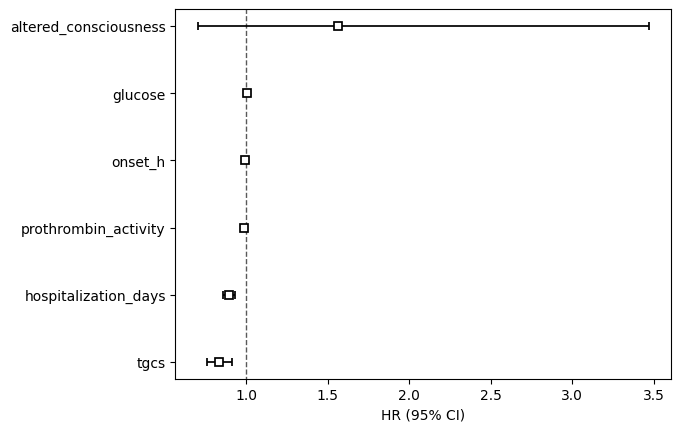

In [31]:
cph.plot(hazard_ratios=True)

### 4.4. Cox Net - regression with elastic net penalty

- **Optimization of hyperparameters**
    - Alpha ($\alpha$) analysis
    - Analysis of all parameters
- **Analysis of the best model**
- **Repeat excluding days of hospitalization**
- **Bootstrapping confidence intervals**
- **Predictions: Survival and Cumulative Hazard Function**

*Cox regression* model can be improve by adding regularization: **ridge** ($l2$) and **lasso** ($l1$). The resulting objective is a ***penalized Cox model***, often referred to as ***ridge*** or ***lasso regression***. The addition of regularization adds a new hiperparameter which should be optimize $\alpha$. As bigger $\alpha$ as more regularization is applied. If $\alpha$ = 0, the model obtained is the standard *Cox regression*. There is a third approach to regularize the *Cox model*, the ***elastic net penalty***, which combines $l2$ and $l1$ regularizations. The *elastic net penalty* combines the subset selection property of the *lasso* with the regularization strength of the *ridge penalty*. This penalty adds a new hiperparameter $r$, which is the relative weight of the $l2$ and $l1$ regularizations (high $r$ values gives more weight to *lasso*).

###### NOTE

Linear models, like *Cox regression*, do not require to normalize or to standarize the inputs, nervertheless, when adding *lasso* and *ridge* penalization it is a good practice to standarize the inputs. Therefore, a pipeline including feature standarization before *Cox regression* is implemented in the following examples. However, it is needed to have **careful**, since the interpretation of the coefficients changes, they **refered to the standarize variables, and not to the orginal variables**.

#### 4.4.1. Optimization of hyperparameters

   - **Pipeline**: **standarization** + ***Cox net***.
   - Search **best parameters**: $\alpha$, $r$ (*l1_ratio*), and tol (*tolerance*).

In [32]:
# Set fitting data
X_data= df_cox_vars
y_data= y_cox

#### 4.4.1.1. Alpha ($\alpha$) analysis

In [33]:
# Make a little pipeline just to get alphas generated by the model class
alphas_pipe= make_pipeline(StandardScaler(),
                           CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)).fit(X_data, y_data)

alphas= alphas_pipe.named_steps['coxnetsurvivalanalysis'].alphas_

# Build pipeline, GridSearch and fit
coxnet_alpha_gcv= GridSearchCV(make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
                               param_grid={'coxnetsurvivalanalysis__alphas': [[v] for v in alphas]},
                               cv=KFold(n_splits=5, shuffle=True, random_state=0),
                               error_score=0.5,
                               n_jobs=1).fit(X_data, y_data)

coxnet_alpha_cv_results= pd.DataFrame(coxnet_alpha_gcv.cv_results_)

We can visualize the results by plotting the *mean concordance index* and its standard deviation across all folds for each 
$\alpha$.

Best α: 0.0072


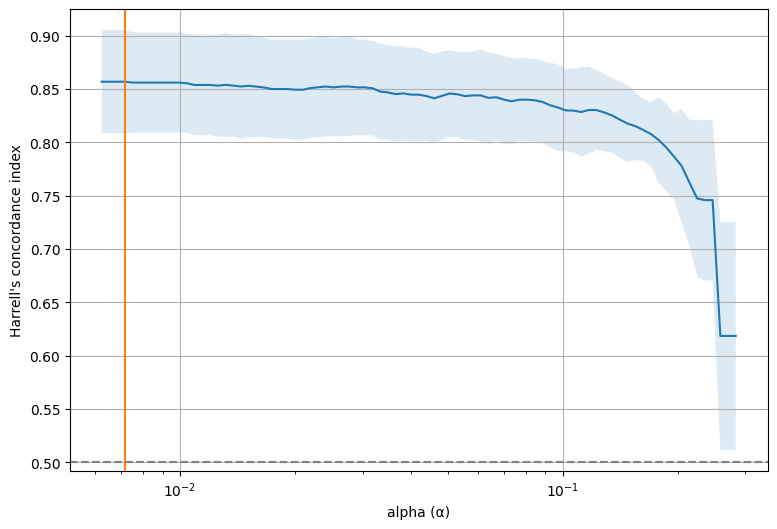

In [34]:
alphas= coxnet_alpha_cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean= coxnet_alpha_cv_results.mean_test_score
std= coxnet_alpha_cv_results.std_test_score

fig, ax= plt.subplots(figsize=(9,6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean-std, mean+std, alpha=.15)
ax.set_xscale('log')
ax.set_ylabel('Harrell\'s concordance index')
ax.set_xlabel('alpha (\u03B1)')
ax.axvline(coxnet_alpha_gcv.best_params_['coxnetsurvivalanalysis__alphas'][0], c='C1')
ax.axhline(0.5, color='grey', linestyle='--')
ax.grid(True)

print('Best \u03B1: %.4f' % (coxnet_alpha_gcv.best_params_['coxnetsurvivalanalysis__alphas'][0]))

#### 4.4.1.2. Analysis of all parameters

Searching for more hyperparameters.

In [35]:
# Set fitting data
#X_data= df_cox_vars
#y_data= y_cox

# Build the pipeline
standarization= StandardScaler()
coxnet= CoxnetSurvivalAnalysis(max_iter=100) # Hyperparameters already fixed

coxnet_pipe= make_pipeline(standarization,coxnet)


# Build de GridSearch
param_grid= {'coxnetsurvivalanalysis__alphas':  [[alpha] for alpha in alphas],
             'coxnetsurvivalanalysis__l1_ratio':[l1_ratio/10 for l1_ratio in range(1,10)],
             'coxnetsurvivalanalysis__tol':     [1e-6,1e-7,1e-8]}

cv= KFold(n_splits=5, shuffle=True, random_state=0)

coxnet_gcv= GridSearchCV(estimator=coxnet_pipe,
                         param_grid=param_grid,
                         cv=cv,
                         error_score=0.5,
                         n_jobs=1)

# Fit the model
t0= time()
coxnet_gcv.fit(X_data, y_data)
tcv= time()-t0

# Summary
print('cv time: %0.3f min'%(tcv/60))
print('Best parameters:', coxnet_gcv.best_params_)
coxnet_gcv

cv time: 1.513 min
Best parameters: {'coxnetsurvivalanalysis__alphas': [0.006243049594432657], 'coxnetsurvivalanalysis__l1_ratio': 0.2, 'coxnetsurvivalanalysis__tol': 1e-06}


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=0.5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('coxnetsurvivalanalysis',
                                        CoxnetSurvivalAnalysis(max_iter=100))]),
             n_jobs=1,
             param_grid={'coxnetsurvivalanalysis__alphas': [[0.28311471430973406],
                                                            [0.2702467136026127],
                                                            [0.2579635833873066],
                                                            [0.2462387403973099],
                                                            [0.2...
                                                            [0.11698335101829331],
                                                            [0.11166627716964148],
                                                            [0.10659087253345387],
                                                            [0.10174615287104667],
                                                            [0.09712163319433664],
                                                            [0.0927073050741308],
                                                            [0.08849361497978937],
                                                            [0.0844714436033845],
                                                            [0.08063208612360784],
                                                            [0.07696723336671395],
                                                            [0.07346895382372802], ...],
                         'coxnetsurvivalanalysis__l1_ratio': [0.1, 0.2, 0.3,
                                                              0.4, 0.5, 0.6,
                                                              0.7, 0.8, 0.9],
                         'coxnetsurvivalanalysis__tol': [1e-06, 1e-07, 1e-08]})

In [36]:
# Results
coxnet_cv_results= pd.DataFrame(coxnet_gcv.cv_results_)
coxnet_cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,param_coxnetsurvivalanalysis__l1_ratio,param_coxnetsurvivalanalysis__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005391,0.001593,0.002396,0.000855,[0.28311471430973406],0.1,0.000001,{'coxnetsurvivalanalysis__alphas': [0.28311471...,0.832787,0.863787,0.863454,0.862745,0.76834,0.838223,0.036891,1807
1,0.004480,0.000973,0.002327,0.000683,[0.28311471430973406],0.1,0.0,{'coxnetsurvivalanalysis__alphas': [0.28311471...,0.832787,0.860465,0.863454,0.862745,0.76834,0.837558,0.036452,1814
2,0.004206,0.000778,0.002364,0.000911,[0.28311471430973406],0.1,0.0,{'coxnetsurvivalanalysis__alphas': [0.28311471...,0.832787,0.860465,0.863454,0.862745,0.76834,0.837558,0.036452,1814


#### 4.4.2. Analysis of the best model

In [37]:
# Harrell's c-index
best_coxnet_mean_cindex, best_coxnet_std_cindex= coxnet_cv_results[coxnet_cv_results['rank_test_score'] == 1][['mean_test_score', 'std_test_score']].values[0]

print('Model c-index:', np.round(best_coxnet_mean_cindex,4), '±', np.round(best_coxnet_std_cindex,4))

Model c-index: 0.8591 ± 0.0491


In [38]:
# Obtain best coefficients
best_coxnet= coxnet_gcv.best_estimator_.named_steps['coxnetsurvivalanalysis']

best_coefs= pd.DataFrame(best_coxnet.coef_, index=X_data.columns, columns=['coefficient'])
best_coefs['hazard ratio [exp(\u03B2)]']= np.exp(best_coxnet.coef_)
round(best_coefs,4)

,coefficient,hazard ratio [exp(β)]
hospitalization_days,-1.3781,0.2521
tgcs,-0.6626,0.5155
glucose,0.3042,1.3556
altered_consciousness,0.2201,1.2462
onset_h,-0.5563,0.5733
prothrombin_activity,-0.3024,0.7390


Number of non-zero coefficients: 6


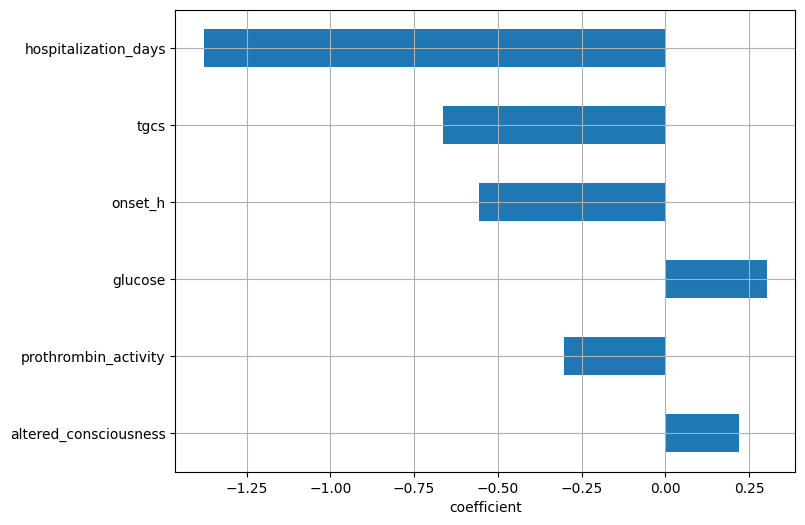

In [39]:
# Select non-zero coefficients
non_zero= np.sum(best_coefs.iloc[:,0] != 0)
print('Number of non-zero coefficients: {}'.format(non_zero))

non_zero_coefs= best_coefs.query('coefficient != 0')
coef_order= non_zero_coefs.abs().sort_values('coefficient').index

# Plot non-zero coefficients
_, ax= plt.subplots(figsize=(8,6))
non_zero_coefs.loc[coef_order,'coefficient'].plot.barh(ax=ax, legend=False)
ax.set_xlabel('coefficient')
ax.grid(True)

#### 4.4.3. Repeat excluding days of hospitalization 

cv time: 1.445 min
Best parameters: {'coxnetsurvivalanalysis__alphas': [0.0927073050741308], 'coxnetsurvivalanalysis__l1_ratio': 0.1, 'coxnetsurvivalanalysis__tol': 1e-06}
Model c-index: 0.7809 ± 0.0752
Number of non-zero coefficients: 5


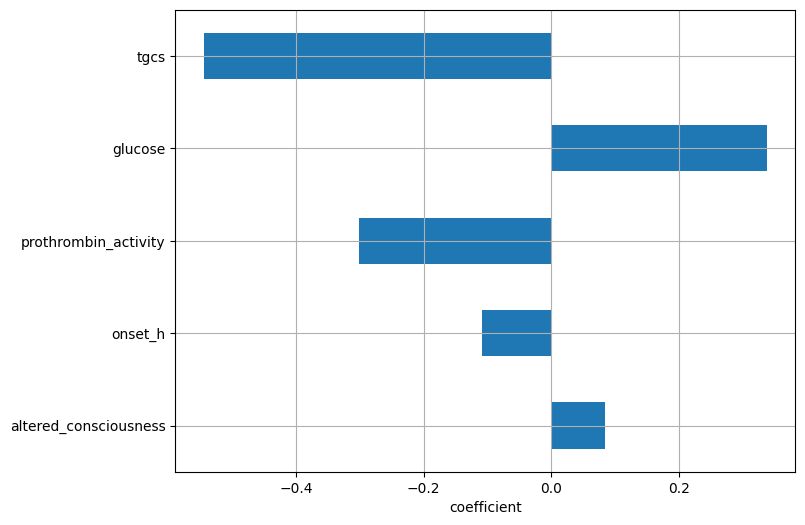

In [40]:
# Set fitting data
X_data2= df_cox_vars2 # remove hospitalization days
y_data2= y_cox2

coxnet2_gcv= GridSearchCV(estimator=coxnet_pipe,
                          param_grid=param_grid,
                          cv=cv,
                          error_score=0.5,
                          n_jobs=1)

# Fit the model
t0= time()
coxnet2_gcv.fit(X_data2, y_data2)
tcv2= time()-t0

# Summary
print('cv time: %0.3f min'%(tcv2/60))
print('Best parameters:', coxnet2_gcv.best_params_)

# Results
coxnet2_cv_results= pd.DataFrame(coxnet2_gcv.cv_results_)

# Harrell's c-index
best_coxnet2_mean_cindex, best_coxnet2_std_cindex= coxnet2_cv_results[coxnet2_cv_results['rank_test_score'] == 1][['mean_test_score', 'std_test_score']].values[0]
print('Model c-index:', np.round(best_coxnet2_mean_cindex,4), '±', np.round(1.96*best_coxnet2_std_cindex,4))

# Coefficients
best_coxnet2= coxnet2_gcv.best_estimator_.named_steps['coxnetsurvivalanalysis']

best_coefs2= pd.DataFrame(best_coxnet2.coef_, index=X_data2.columns, columns=['coefficient'])
best_coefs2['hazard ratio [exp(\u03B2)]']= np.exp(best_coxnet2.coef_)
round(best_coefs2,4)

# Select non-zero coefficients
non_zero2= np.sum(best_coefs2.iloc[:,0] != 0)
print('Number of non-zero coefficients: {}'.format(non_zero2))

non_zero_coefs2= best_coefs2.query('coefficient != 0')
coef_order2= non_zero_coefs2.abs().sort_values('coefficient').index

# Plot non-zero coefficients
_, ax= plt.subplots(figsize=(8,6))
non_zero_coefs2.loc[coef_order2,'coefficient'].plot.barh(ax=ax, legend=False)
ax.set_xlabel('coefficient')
ax.grid(True)

#### 4.4.4. Bootstrapping confidence intervals

In [41]:
# Define a bootstrapping validation function for Cox Net
def boots_validation_coxnet (x, y, train_size, n_iterations, alpha):
    
    idx= list(range(x.shape[0]))
    train_size= int(x.shape[0]*train_size)
    x_, y_= shuffle(x,y) # shuffle to take random folds
    
    c_indexes= []
    c_unos= []
    for i in tqdm(range(n_iterations)):        
        idx_train= random.choices(idx, k=train_size) # samples with replacement
        idx_test= list(set(idx) - set(idx_train)) # samples will have different size, because of training sample replacement
                
        standarization= StandardScaler()
        coxnet= CoxnetSurvivalAnalysis(max_iter=100, alphas=np.array([0.093]), l1_ratio=0.1, tol=1e-06)

        coxnet_pipe4= make_pipeline(standarization,coxnet)
        coxnet_pipe4.fit(x_.values[idx_train,], y_[idx_train])

        c_index= coxnet_pipe4.score(x_.values[idx_test], y_[idx_test]) # c-index
        prediction= coxnet_pipe4.predict(x_.values[idx_test])
        c_uno= concordance_index_ipcw(y_[idx_train], y_[idx_test], prediction) # Uno's c-index
        
        c_indexes.append(c_index)
        c_unos.append(c_uno[0])
                
    # confidence intervals
    pl= alpha/2*100
    pu= ((1-alpha) + (alpha/2))*100
    
    c_index_median= np.median(c_indexes)
    c_index_lower= max(0.0, np.percentile(c_indexes, pl))
    c_index_upper= min(1.0, np.percentile(c_indexes, pu))

    c_uno_median= np.median(c_unos)
    c_uno_lower= max(0.0, np.percentile(c_unos, pl))
    c_uno_upper= min(1.0, np.percentile(c_unos, pu))
    
    
    return (c_indexes, c_unos,
           (c_index_median,c_index_lower,c_index_upper),
           (c_uno_median,c_uno_lower,c_uno_upper))

In [42]:
coxnet_c, coxnet_c_unos, coxnet_ci_c, coxnet_ci_c_unos= boots_validation_coxnet (x=df_cox_vars2, y=y_cox2, train_size=0.8, n_iterations=10000, alpha=0.05)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'c_uno: 0.7691, 95%CI 0.6902 and 0.8393')

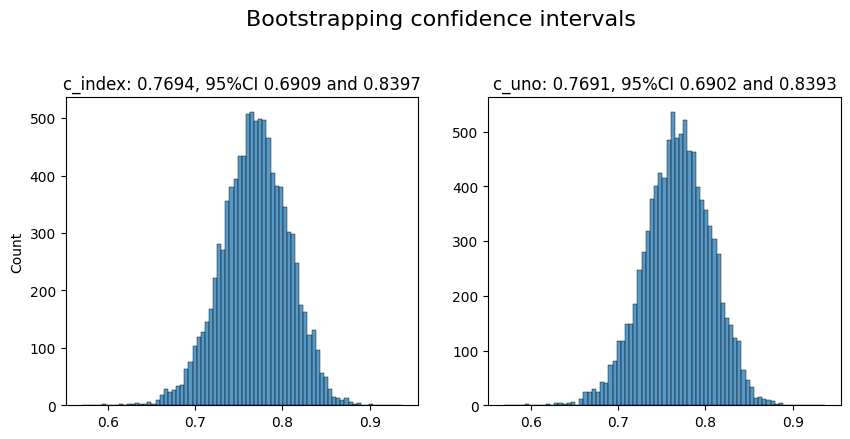

In [43]:
fig, axs= plt.subplots(1,2, figsize=(10,4))
fig.suptitle('Bootstrapping confidence intervals', y=1.1, size=16)

sns.histplot(coxnet_c, ax=axs[0])
sns.histplot(coxnet_c_unos, ax=axs[1])

axs[1].set_ylabel('')

axs[0].set_title('c_index: %.4f, %.0f%%CI %.4f and %.4f' % (coxnet_ci_c[0],      (1-alpha)*100, coxnet_ci_c[1],      coxnet_ci_c[2]))
axs[1].set_title('c_uno: %.4f, %.0f%%CI %.4f and %.4f' % (coxnet_ci_c_unos[0], (1-alpha)*100, coxnet_ci_c_unos[1], coxnet_ci_c_unos[2]))

#### 4.4.5. Predictions: Survival and Cumulative Hazard Function

Finally, having selected the optimal hyperparameters, it is posible to perform predictions:
 - In terms of **risk score** (predict function).
 - In terms of **survival** or **cumulative hazard function**. 

In [44]:
# To make predictions, set fit_baseline_model=True
coxnet_pred= make_pipeline(StandardScaler(),
                           CoxnetSurvivalAnalysis(fit_baseline_model=True))

coxnet_pred.set_params(**coxnet_gcv.best_params_) # optimal hyperparameters
coxnet_pred.fit(X_data, y_data)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.006243049594432657],
                                        fit_baseline_model=True, l1_ratio=0.2,
                                        tol=1e-06))])

Text(0.5, 1.0, 'Cumulative hazard function $H(t)$')

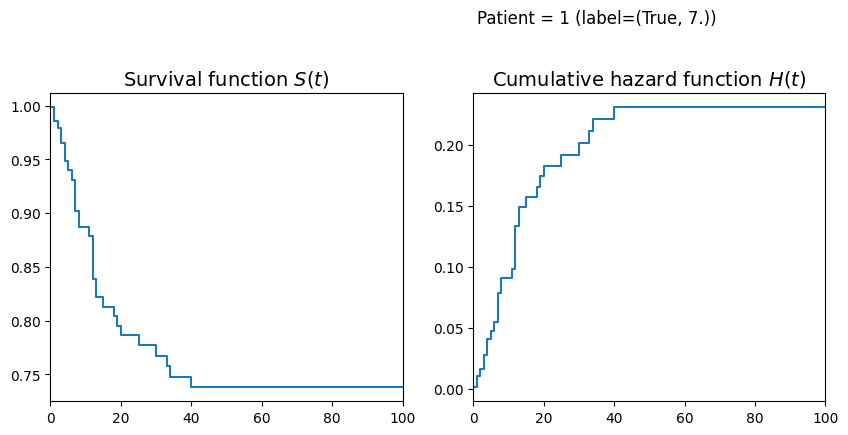

In [45]:
# Predict a patient
patient=1
pred_survival= coxnet_pred.predict_survival_function(X_data.iloc[[patient,]])
pred_hazard= coxnet_pred.predict_cumulative_hazard_function(X_data.iloc[[patient,]])

fig, axs= plt.subplots(1,2, figsize=(10,4))
plt.text(1, 0.3, 'Patient = ' + str(patient) + ' (label=' + str(y_data[patient]) + ')', fontsize=12)

axs[0].step(pred_survival[0].x, pred_survival[0].y, where='post')
axs[1].step(pred_hazard[0].x,   pred_hazard[0].y,   where='post')
axs[0].set_xlim((0,100))
axs[1].set_xlim((0,100))
axs[0].set_title('Survival function $S(t)$', fontsize=14)
axs[1].set_title('Cumulative hazard function $H(t)$', fontsize=14)